In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import warnings
import datetime
import json
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from model_generator_aemet import *

In [3]:
from nltk.corpus import stopwords

#### Read aemet forecast and band price

In [4]:
aemet = pd.read_csv('Province_prediction_text/merged.csv', encoding='latin1')

In [5]:
aemet_daily_forecast = aemet.groupby(['date'])['prediction'].apply(', '.join).to_frame()

In [6]:
paths_dict_band = json.load(open('paths_dict_band.json', 'r'))

In [7]:
band_model = generate_df(paths_dict_band, 'band', '2016')

In [8]:
band = band_model.return_completed_df()

In [9]:
aemet_band = aemet_daily_forecast.merge(band.groupby('date')[['band']].mean().rename(columns={'band':'mean'}), how='left', left_index=True,
                           right_index=True)
aemet_band = aemet_band.merge(band.groupby('date')[['band']].std().rename(columns={'band':'std'}), how='left',
                            left_index=True, right_index=True)

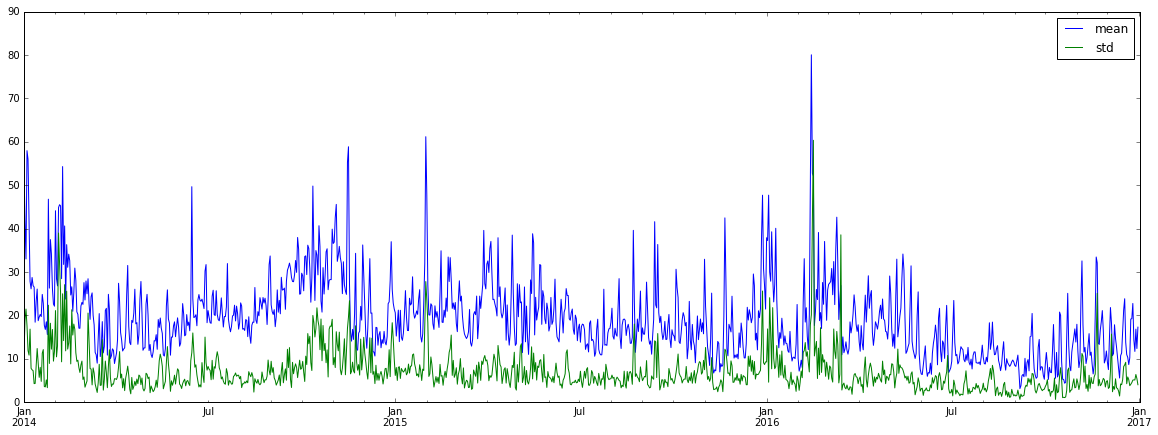

In [10]:
aemet_band[['mean', 'std']].plot(figsize=(20,7));

#### Create pipeline to predict daily vol/mean based on weather forecast

Mean

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [12]:
pipeline_mean = make_pipeline(
        TfidfVectorizer(stop_words=stopwords.words('spanish'),
                       min_df=0.05,
                       max_df=0.95,
                       strip_accents='unicode',
                       norm='l2',
                       sublinear_tf=True),
        SelectFromModel(Lasso(alpha=0.00001, random_state=0)),
        Ridge(alpha=1.5, random_state=0))

In [13]:
mean_model = train_model(df=aemet_band[aemet_band.index < '2017'], features='prediction', output='mean', features_to_remove=[],
                         n_folds=5)

In [14]:
mean_model.obtain_cv_score(pipeline_mean)

Mean absolute error: 4.9980 +- 0.5114
Mean squared error: 48.3199 +- 19.1139


In [15]:
mean_model.obtain_train_test_error(pipeline_mean)

Train MAE: 4.28872061649, Train MSE: 35.0641567955
Test MAE: 4.86436174731, Test MSE: 39.5510825305


In [16]:
mean_model.return_largest_tf('2016-07-01', 30)

julio           0.279204
sabado          0.232307
2016            0.169198
generalmente    0.168298
36              0.157213
37              0.151334
38              0.149426
35              0.147730
tormentosos     0.143325
permanecen      0.134242
lloviznas       0.129704
34              0.127349
evolucion       0.123564
diurna          0.119723
32              0.115654
01              0.115109
31              0.110431
llegar          0.109201
importantes     0.108990
29              0.101847
occidentales    0.099695
33              0.096388
regimen         0.093816
28              0.092756
despejados      0.091006
30              0.090284
guadalquivir    0.088763
nubosidad       0.087605
excepto         0.086339
atlantico       0.085443
Name: 2016-07-01 00:00:00, dtype: float64


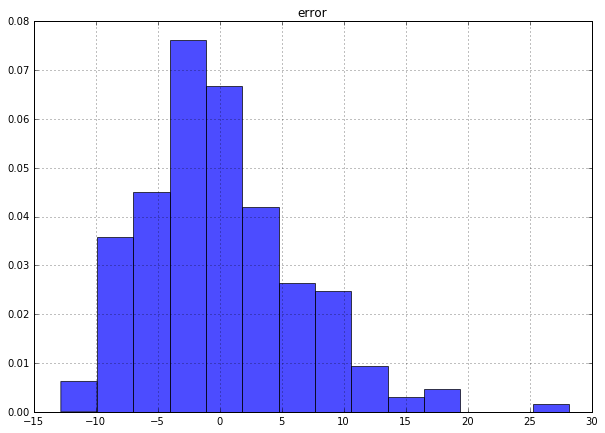

In [17]:
mean_model.plot_histogram_error(0.7)

Volatility

In [18]:
pipeline_vol = make_pipeline(
        TfidfVectorizer(stop_words=stopwords.words('spanish'),
                       min_df=0.05,
                       max_df=0.95,
                       strip_accents='unicode',
                       norm='l2',
                       sublinear_tf=True,),
        SelectFromModel(Lasso(alpha=0.00001, random_state=0)),
        Ridge(alpha=1.75, random_state=0))

In [19]:
volatility_model = train_model(df=aemet_band[aemet_band.index < '2017'], features='prediction', 
                              output='std', features_to_remove=[], n_folds=5)

In [20]:
volatility_model.obtain_cv_score(pipeline_vol)

Mean absolute error: 2.5801 +- 0.2337
Mean squared error: 14.8116 +- 5.7974


In [21]:
volatility_model.obtain_train_test_error(pipeline_vol)

Train MAE: 2.25181666122, Train MSE: 11.1860558416
Test MAE: 2.57603198064, Test MSE: 23.3592252343


In [22]:
volatility_model.return_largest_tf('2016-01-29', 30)

enero          0.335852
sabado         0.279440
2016           0.203527
29             0.160244
predominar     0.153163
heladas        0.147820
30             0.142053
nieblas        0.131687
01             0.130852
aumento        0.125173
brumas         0.119277
mancha         0.118870
montes         0.113169
medias         0.112237
intensidad     0.108523
bancos         0.107528
primera        0.105969
descartan      0.105077
acompanadas    0.103867
diurnas        0.100951
montanas       0.100282
niebla         0.100272
girando        0.098752
nubes          0.098269
intervalo      0.098264
matinales      0.096734
altas          0.095174
nocturnas      0.090976
debiles        0.090490
pocos          0.090105
Name: 2016-01-29 00:00:00, dtype: float64


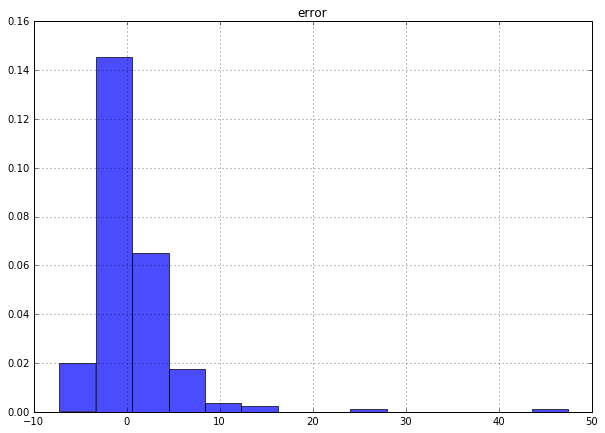

In [23]:
volatility_model.plot_histogram_error(0.7)

### Meta-model 

In [ ]:
mean_metamodel = metamodel(features='prediction', pipeline=pipeline_mean, 
                           n_folds=5, num_cv=4, metric={'mae': mean_absolute_error,
                                                        'mse': mean_squared_error})

In [ ]:
index, oos_mean = mean_metamodel.get_oos_cv_predictions(x_train=aemet_band[aemet_band.index < '2017'].reset_index(),
                                                       y_train = aemet_band[aemet_band.index < '2017']['mean'].values,
                                                       index_col='index')

In [ ]:
vol_metamodel = metamodel(features='prediction', pipeline=pipeline_vol, 
                           n_folds=5, num_cv=4, metric={'mae': mean_absolute_error,
                                                        'mse': mean_squared_error})

In [ ]:
index, oos_vol = vol_metamodel.get_oos_cv_predictions(x_train=aemet_band[aemet_band.index < '2017'].reset_index(),
                            y_train = aemet_band[aemet_band.index < '2017']['std'].values,
                            index_col='index')

In [ ]:
pd.DataFrame({'pred_band_mean_aemet':oos_mean, 'pred_band_vol_aemet':oos_vol},
            index=index).to_csv('band_mean_vol_pred_aemet.csv')

In [ ]:
pd.DataFrame({'pred_band_mean_aemet':oos_mean, 'pred_band_vol_aemet':oos_vol},
            index=index).merge(aemet_band[['mean', 'std']], how='left', 
                               left_index=True, right_index=True).plot(figsize=(20,10));

### Mean and volatily predictions for 2017

In [87]:
aemet_2017 = pd.read_csv('Province_prediction_text_2017/merged_2017.csv', encoding='latin1')

In [88]:
aemet_2017_daily_forecast = aemet_2017.groupby(['date'])['prediction'].apply(', '.join).to_frame()

In [89]:
aemet_2017_daily_forecast = aemet_2017_daily_forecast[aemet_2017_daily_forecast.index < '2017-03-19']

In [90]:
band_model_2017 = generate_df(paths_dict_band, 'band', '2017')

In [91]:
band_2017 = band_model_2017.return_completed_df()

In [92]:
aemet_band_2017 = aemet_2017_daily_forecast.merge(band_2017.groupby('date')[['band']].mean().rename(columns={'band':'mean'}), how='left', left_index=True,
                           right_index=True)
aemet_band_2017 = aemet_band_2017.merge(band_2017.groupby('date')[['band']].std().rename(columns={'band':'std'}), how='left',
                            left_index=True, right_index=True)

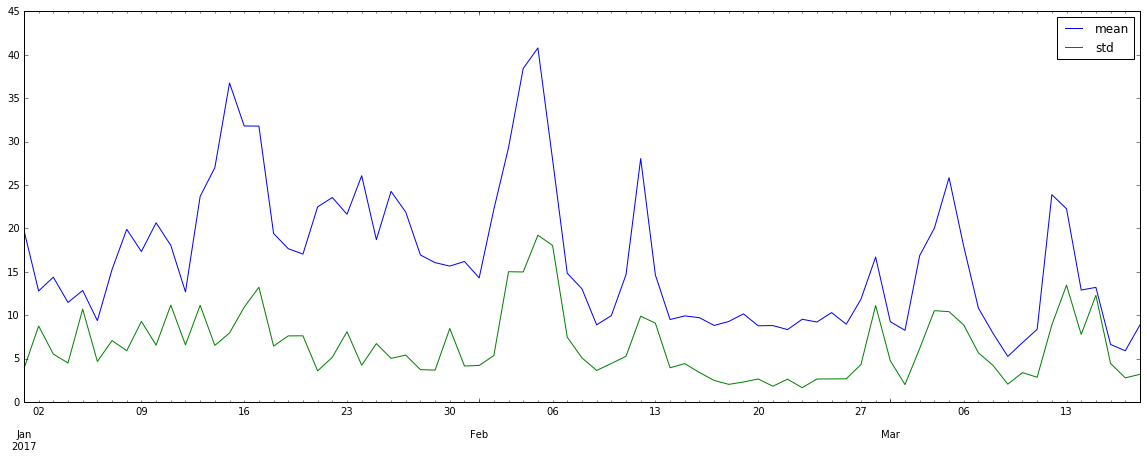

In [93]:
aemet_band_2017[['mean', 'std']].plot(figsize=(20,7));

In [94]:
aemet_band_2017['pred_mean'] = mean_model.predict_2017_samples(aemet_band_2017['prediction'])
aemet_band_2017['pred_std'] = volatility_model.predict_2017_samples(aemet_band_2017['prediction'])

In [96]:
for feature in ['mean', 'std']:
    aemet_band_2017['error_'+feature] = np.abs(aemet_band_2017[feature] - aemet_band_2017['pred_'+feature])
    print('MAE for ' + feature +' : ' + str(mean_absolute_error(aemet_band_2017[feature], aemet_band_2017['pred_'+feature])))

MAE for mean : 6.21743941897
MAE for std : 3.6368292553


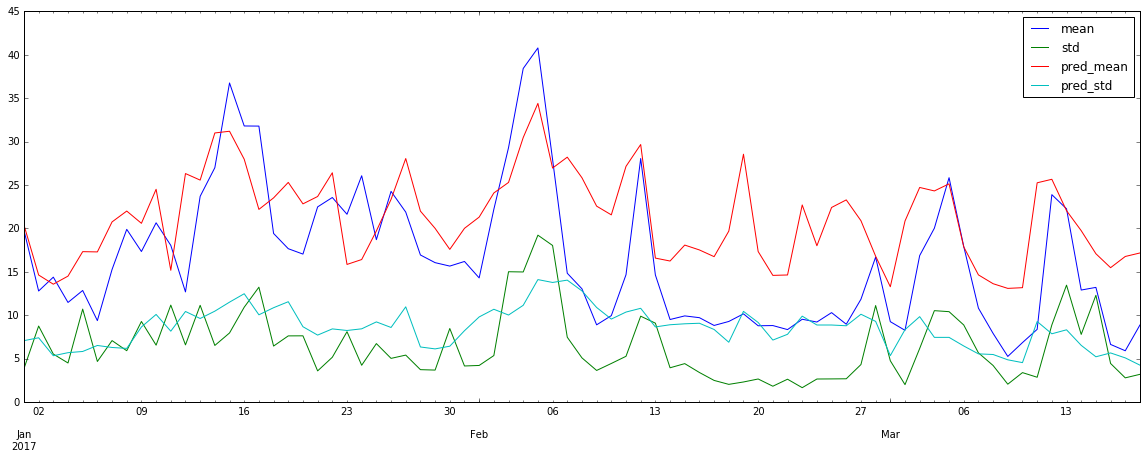

In [97]:
aemet_band_2017[['mean', 'std', 'pred_mean', 'pred_std']].plot(figsize=(20,7));

In [102]:
aemet_band_2017[['pred_mean', 'pred_std']].rename(columns={'pred_mean':'pred_band_mean_aemet',
                                                          'pred_std':'pred_band_vol_aemet'}).to_csv('band_mean_vol_pred_aemet_2017.csv')